In [1]:
import os
import pandas as pd
from datetime import datetime

# === HÀM TIỀN XỬ LÝ ===
def preprocess(data, start=None, end=None):
    if isinstance(data, str):
        df = pd.read_csv(data)
    elif isinstance(data, pd.DataFrame):
        df = data.copy()
    else:
        raise ValueError("data phải là đường dẫn csv hoặc pandas.DataFrame")

    rename_map = {'time': 'DATE', 'tmax': 'TMAX', 'tmin': 'TMIN'}
    df = df.rename(columns=rename_map)

    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df = df.dropna(subset=['DATE']).sort_values('DATE').reset_index(drop=True)

    if start is not None:
        df = df[df['DATE'] >= pd.to_datetime(start)]
    if end is not None:
        df = df[df['DATE'] <= pd.to_datetime(end)]
    df = df.reset_index(drop=True)

    full_range = pd.date_range(df['DATE'].min(), df['DATE'].max(), freq='D')
    df_full = pd.DataFrame({'DATE': full_range})
    df = pd.merge(df_full, df, on='DATE', how='left')

    df['DAY'] = df['DATE'].dt.day
    df['MONTH'] = df['DATE'].dt.month
    df['YEAR'] = df['DATE'].dt.year

    leap_mask = (df['MONTH'] == 2) & (df['DAY'] == 29)
    if leap_mask.any():
        df = df.loc[~leap_mask].reset_index(drop=True)

    return df


# === CẤU HÌNH ===
STATION_FILE = "Station List Meteostat.xlsx"
DATA_FOLDER = r"Weather Database Meteostat 2"

start_date = "2020-07-01"
end_date   = "2024-12-31"

station_list = ["72530", "72421"]

stations_df = pd.read_excel(STATION_FILE, dtype={"Station ID": str})
stations_df["Station ID"] = stations_df["Station ID"].str.strip()

results = []

for station_id in station_list:
    file_path = os.path.join(DATA_FOLDER, f"{station_id}.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ Không tìm thấy file cho trạm {station_id}")
        continue

    df = preprocess(file_path, start=start_date, end=end_date)
    city = stations_df.loc[stations_df["Station ID"] == station_id, "City"].values
    city = city[0] if len(city) else station_id

    # Tạo cột missing
    df["MISS"] = df["TMAX"].isna() | df["TMIN"].isna()

    # Tính missing trong giai đoạn yêu cầu
    mask = (df["DATE"] >= pd.to_datetime(start_date)) & (df["DATE"] <= pd.to_datetime(end_date))
    total_missing = df.loc[mask, "MISS"].sum()
    total_days = mask.sum()
    missing_pct = round(total_missing / total_days * 100, 2)

    record = {
        "Station ID": station_id,
        "City": city,
        "Missing Days": total_missing,
        "Total Days": total_days,
        "Missing (%)": missing_pct
    }

    results.append(record)

# Output
missing_summary = pd.DataFrame(results)
print(missing_summary)

  Station ID        City  Missing Days  Total Days  Missing (%)
0      72530     Chicago             0        1644          0.0
1      72421  Cincinnati             0        1644          0.0


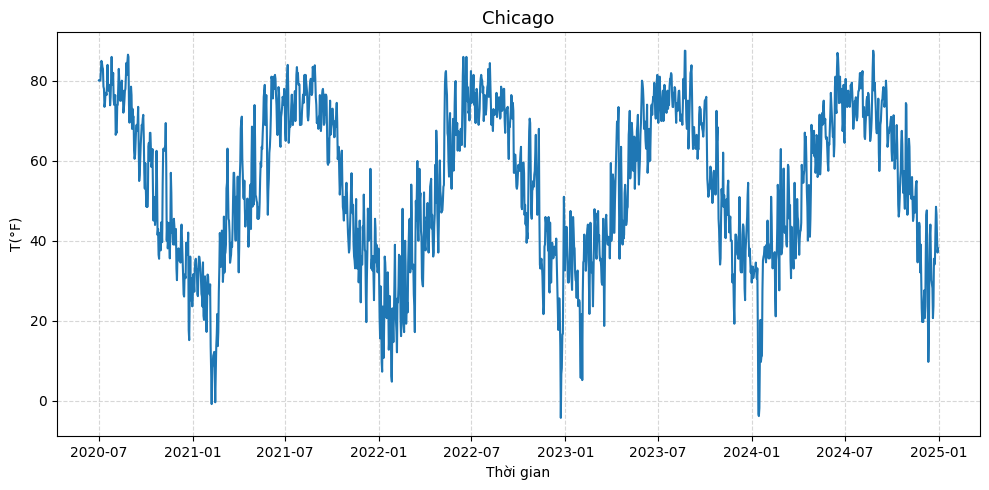

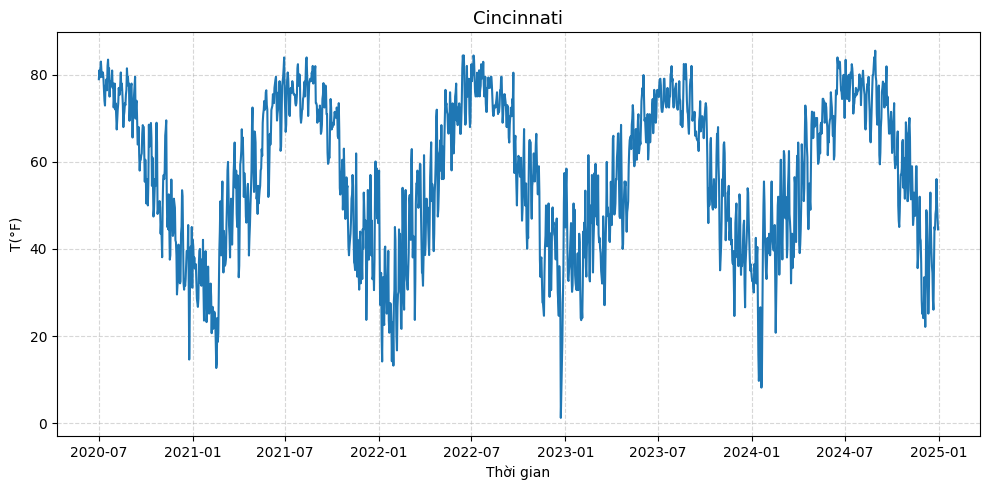

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import functions as f  

# === Cấu hình ===
STATION_FILE = "Station List Meteostat.xlsx"
DATA_FOLDER = r"Weather Database Meteostat 2"
OUTPUT_FILE_RECENT = "Weather_Descriptive_Statistics_2020_2024.xlsx"

station_list = ["72530", "72421"]

# Đọc station info
stations_df = pd.read_excel(STATION_FILE, dtype={"Station ID": str})
stations_df["Station ID"] = stations_df["Station ID"].str.strip()

# --- Hàm tính thống kê mô tả ---
def compute_stats(df, station_id, city):
    t = df["T"].dropna()
    if t.empty:
        return None

    desc = t.describe(percentiles=[0.25, 0.5, 0.75])
    stats = {
        "Station ID": station_id,
        "City": city,
        "count": int(desc["count"]),
        "mean": float(desc["mean"]),
        "std": float(desc["std"]),
        "var": float(np.var(t, ddof=1)),
        "CV": float(desc["std"] / desc["mean"]) if desc["mean"] != 0 else np.nan,
        "skewness": float(skew(t)),
        "kurtosis": float(kurtosis(t)),
        "min": float(desc["min"]),
        "25%": float(desc["25%"]),
        "50%": float(desc["50%"]),
        "75%": float(desc["75%"]),
        "max": float(desc["max"])
    }
    return stats


rows_recent = []

for station_id in station_list:

    data_path = os.path.join(DATA_FOLDER, f"{station_id}.csv")
    if not os.path.exists(data_path):
        print(f"⚠️ Không tìm thấy file dữ liệu cho Station {station_id}.")
        continue

    try:
        # ---- Chỉ lấy dữ liệu cho period này ----
        df_recent = f.preprocess(data_path, start="2020-07-01", end="2024-12-31")

        if df_recent is None or df_recent.empty:
            print(f"⚠️ Station {station_id}: df_recent rỗng.")
            continue

        if 'T' not in df_recent.columns or 'DATE' not in df_recent.columns:
            print(f"⚠️ Station {station_id}: dữ liệu không hợp lệ (thiếu T hoặc DATE).")
            continue

        # Lấy tên thành phố
        city = stations_df.loc[stations_df["Station ID"] == station_id, "City"]
        city = city.values[0] if not city.empty else station_id

        # --- Tính thống kê ---
        stats_recent = compute_stats(df_recent, station_id, city)
        if stats_recent:
            rows_recent.append(stats_recent)

        # --- Vẽ đồ thị ---
        plt.figure(figsize=(10, 5))
        plt.plot(df_recent["DATE"], df_recent["T"], color='tab:blue')
        plt.title(f"{city}", fontsize=13)
        plt.xlabel("Thời gian")
        plt.ylabel("T(°F)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Lỗi khi xử lý station {station_id}: {e}")




In [7]:
print(pd.DataFrame(rows_recent))

  Station ID        City  count       mean        std         var        CV  \
0      72530     Chicago   1644  54.163808  19.156266  366.962515  0.353673   
1      72421  Cincinnati   1644  56.979015  17.104407  292.560734  0.300188   

   skewness  kurtosis  min   25%     50%     75%    max  
0 -0.353143 -0.773738 -4.3  39.0  55.500  71.175  87.55  
1 -0.389389 -0.829033  1.2  43.5  58.525  72.500  85.55  
